
<center><h1>Activity recognition with healthy older people</h1></center>
<center><h3>Conditional random field, sklearn-crfsuite</h3></center>

1. The activity recognition project uses publically available data on [UCI](https://archive.ics.uci.edu/ml/datasets/Activity+recognition+with+healthy+older+people+using+a+batteryless+wearable+sensor).
2. Please refer the paper [Shinmoto Torres, R. L. et, al. In 2013 IEEE International Conference on RFID (pp. 191-198)](http://alansonsample.com/publications/docs/2013%20-%20IEEERFID%20-%20Sensor%20enabled%20wearable%20RFID%20technology%20for%20mitigating%20the%20risk%20of%20falls%20near%20beds.pdf) for the data collection information.
3. Conditional random field (CRF) model is used for this sequential classification problem, the Python machine learning package is available as [sklearn-crfsuite](https://sklearn-crfsuite.readthedocs.io/en/latest/).

## 1. Import library

In [1]:
import numpy as np
import pandas as pd
import os
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from  itertools  import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

## 2. Read data
Function "df2feature_label" is used to convert pandas dataframe to sklearn_crfsuite CRF model data format. 

In [3]:
def df2feature_label(df, interval=10, n=8):
    """
    arguments:
        df: pandas dataframe
        interval: time difference between observations x_t and it prior x_t-1
        n: the number of observations in one sequence
            the selection of interval and n will influence the model performance
    return:
        X, y: the data format for the sklearn_crfsuite CRF model
    """
    
    duration = df["Time"].max()
    X = []
    y = []
    
    for i in range(int(np.floor(duration/interval)) + 1):
        features = []
        labels = []
        for index, row in df.iterrows():
            
            feature = {
#                 "time": row["Time"], ## used to check function acturacy
                "Frontal G": row["Frontal G"],
                "Vertical G": row["Vertical G"],
                "Lateral G": row["Lateral G"],
                "Antenna ID": row["Antenna ID"],
                "RSSI": row["RSSI"],
                "Sine(body tilting angle)": row["Sine(body tilting angle)"]
            }
            label = row["Activity"]
                
            if row["Time"] >= i*interval and row["Time"] < (i+1)*interval:
                features.append(feature)
                labels.append(label)
                
        if len(features) > 0: 
            X.append(features[0])
            y.append(labels[0])
        
    X = [X[i:i+n] for i in range(0, len(X), n)]
    y = [y[i:i+n] for i in range(0, len(y), n)]
    
    return X, y

In [4]:
%%time

directory = os.fsencode(".\Datasets_Healthy_Older_People\S1_Dataset")
columns = ["Time", "Frontal G", "Vertical G", "Lateral G", "Antenna ID", "RSSI", "Phase", "Frequency", 
           "Activity"]
activity = {1: "sit on bed", 2 : "out of bed", 3: "lying on bed", 4: "out of bed"}
##Label of activity, 1: sit on bed, 2: sit on chair, 3: lying, 4: ambulating 

X = []
y = []
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    ## loop through all the subjects' data file, and read them to X, y    
    if not filename.endswith(".txt"):
        path = os.fsdecode(os.path.join(directory, file))
        df = pd.read_csv(path, header=None, names=columns)
        df["Sine(body tilting angle)"] = np.sin(np.arctan(df["Frontal G"]/df["Vertical G"]))
        df.replace({"Activity": activity}, inplace=True)
        
        X_i, y_i = df2feature_label(df, interval=10, n=8)
        X += X_i
        y += y_i

Wall time: 4min 47s


In [5]:
## check input data format
X[22]

[{'Antenna ID': 1,
  'Frontal G': 0.025796,
  'Lateral G': -0.16192,
  'RSSI': -46.5,
  'Sine(body tilting angle)': 0.024732050846430806,
  'Vertical G': 1.0427},
 {'Antenna ID': 2,
  'Frontal G': 0.5534399999999999,
  'Lateral G': 0.031928,
  'RSSI': -57.5,
  'Sine(body tilting angle)': 0.5266222218437318,
  'Vertical G': 0.89339},
 {'Antenna ID': 2,
  'Frontal G': 0.5534399999999999,
  'Lateral G': 0.020525,
  'RSSI': -57.0,
  'Sine(body tilting angle)': 0.5266222218437318,
  'Vertical G': 0.89339},
 {'Antenna ID': 2,
  'Frontal G': 0.5534399999999999,
  'Lateral G': 0.020525,
  'RSSI': -58.0,
  'Sine(body tilting angle)': 0.5266222218437318,
  'Vertical G': 0.89339},
 {'Antenna ID': 2,
  'Frontal G': 0.7176,
  'Lateral G': 0.08894400000000001,
  'RSSI': -57.0,
  'Sine(body tilting angle)': 0.6462142821642965,
  'Vertical G': 0.84746},
 {'Antenna ID': 2,
  'Frontal G': 0.8934799999999999,
  'Lateral G': 0.054735,
  'RSSI': -58.0,
  'Sine(body tilting angle)': 0.7684143976010124,
  'V

## 3. Training CRF model

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [7]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)

In [8]:
%%time
crf.fit(X_train, y_train)

Wall time: 87.8 ms


CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

### 3.1 Model evaluation

In [9]:
y_pred = crf.predict(X_test)

In [10]:
labels = list(crf.classes_)

In [11]:
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)

0.81628790253294103

In [12]:
print(metrics.flat_classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

lying on bed      0.987     0.991     0.989       225
  out of bed      0.700     0.830     0.759       188
  sit on bed      0.731     0.561     0.635       155

 avg / total      0.822     0.820     0.816       568



## 4. Hyperparameter optimization

In [14]:
crf = sklearn_crfsuite.CRF(
    algorithm = "lbfgs",
    max_iterations=100,
    all_possible_transitions=True
)

In [15]:
params = {
    "c1": scipy.stats.expon(scale=0.5),
    "c2": scipy.stats.expon(scale=0.05)   
}

In [16]:
f1_scorer = make_scorer(metrics.flat_f1_score,average='weighted', labels=labels)

In [17]:
rs = RandomizedSearchCV(crf, param_distributions=params, cv=3, n_iter=50, 
                        verbose=1, scoring=f1_scorer, return_train_score=True)

In [18]:
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.3s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=None, c2=None,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error...e,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002412F22C8D0>, 'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002412F22CE80>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True,
          scoring=make_scorer(flat_f1_score, average=weighted, labels=['sit on bed', 'lying on bed', 'out of bed']),
          verbose=1)

### 4.1 Best result

In [19]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 1.6600229064661627, 'c2': 0.081819055585807751}
best CV score: 0.76753415381
model size: 0.01M


### 4.2 Best estimater on test data

In [20]:
crf_best = rs.best_estimator_

In [21]:
y_pred = crf_best.predict(X_test)

In [22]:
print(metrics.flat_classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

lying on bed      0.987     0.991     0.989       225
  out of bed      0.688     0.729     0.708       188
  sit on bed      0.636     0.587     0.611       155

 avg / total      0.792     0.794     0.793       568



## 5 Check what CRF classifier learned

### 5.1 Check parameter space
Check which c1 and c2 values are used in random hyperparameter search, cv score is maped to colors.

In [23]:
x = [s["c1"] for s in rs.cv_results_["params"]]
y = [s["c2"] for s in rs.cv_results_["params"]]
cv = rs.cv_results_["mean_test_score"].tolist()

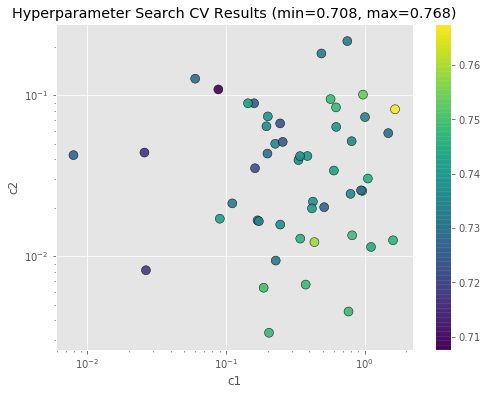

In [24]:
plt.style.use('ggplot')
plt.figure(figsize=(8,6))

plt.yscale('log')
plt.xscale('log')
plt.xlabel('c1')
plt.ylabel('c2')
plt.title("Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(min(cv), max(cv)))

plt.scatter(x, y, c=cv, s=80, alpha=0.9, edgecolors="black")
plt.colorbar()
plt.show()

### 5.2 Check per-class transition

In [25]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-13s -> %-15s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf_best.transition_features_).most_common())

# print("\nTop unlikely transitions:")
# print_transitions(Counter(crf_best.transition_features_).most_common()[: : -1])

Top likely transitions:
out of bed    -> out of bed      2.410660
sit on bed    -> sit on bed      2.013236
lying on bed  -> lying on bed    0.970545
sit on bed    -> lying on bed    0.072984
lying on bed  -> sit on bed      0.028053
lying on bed  -> out of bed      -0.078369
sit on bed    -> out of bed      -0.220270
out of bed    -> lying on bed    -0.447580


### 5.3 Check the state features

In [26]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%-14s  %-30s  %0.4f " % (label, attr, weight))

print_state_features(Counter(crf_best.state_features_).most_common())

sit on bed      Vertical G                      4.5720 
out of bed      Vertical G                      4.4683 
lying on bed    Frontal G                       2.9835 
lying on bed    Lateral G                       1.4497 
sit on bed      Sine(body tilting angle)        0.8315 
out of bed      Sine(body tilting angle)        0.6987 
lying on bed    Antenna ID                      -0.1083 
sit on bed      Antenna ID                      -0.1667 
out of bed      Lateral G                       -0.2273 
out of bed      Antenna ID                      -0.2946 
out of bed      Frontal G                       -0.7373 
sit on bed      Frontal G                       -1.0255 
